# 卷积神经网络

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

net = CNNNet()
net=net.to(device)

### 卷基层

### 池化层

### 经典网络

# CIFAR-10多分类

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# 导入数据

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=8,shuffle=True,num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=8,shuffle=False,num_workers=0)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


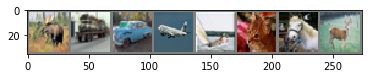

 deer truck   car plane  ship   cat horse  deer


In [4]:
# 随机查看部分数据

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [7]:
# 显示网络中定义的层

print(net)

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# 取出模型中的前四层

nn.Sequential(*list(net.children())[:4])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [24]:
# 初始化参数

for m in net.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.xavier_normal_(m.weight)
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias,0)
    elif isinstance(m,nn.Linear):
        nn.init.normal_(m.weight)

# net.state_dict()

In [6]:
# 选择优化器

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [11]:
# 训练模型

for epoch in range(5):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%2000==1999:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('finished training')

[1,  2000] loss: 2.215
[1,  4000] loss: 2.104
[1,  6000] loss: 2.009
[2,  2000] loss: 1.948
[2,  4000] loss: 1.894
[2,  6000] loss: 1.787
[3,  2000] loss: 1.673
[3,  4000] loss: 1.632
[3,  6000] loss: 1.581
[4,  2000] loss: 1.539
[4,  4000] loss: 1.492
[4,  6000] loss: 1.477
[5,  2000] loss: 1.450
[5,  4000] loss: 1.416
[5,  6000] loss: 1.404
finished training


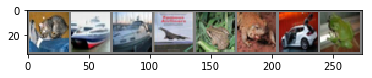

predict:    cat  ship  ship plane  frog  frog   car  frog


In [12]:
# show测试集

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('predict: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))


In [14]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(8)))

predicted:    cat  ship  ship  ship  frog  frog   car  frog


In [15]:
# 测试

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        images,labels = images.to(device),labels.to(device)
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        break

print('Accuracy of the network on the 10000 test images: %d %%'%(100.*correct/total))


Accuracy of the network on the 10000 test images: 87 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 59 %
Accuracy of  bird : 23 %
Accuracy of   cat : 39 %
Accuracy of  deer : 42 %
Accuracy of   dog : 37 %
Accuracy of  frog : 68 %
Accuracy of horse : 55 %
Accuracy of  ship : 60 %
Accuracy of truck : 60 %


In [17]:
print("net_gvp have {} paramerters in total".format(sum(x.numel() for x in net.parameters())))

net_gvp have 173742 paramerters in total


# 6.5.7 像Keras一样显示各层参数

# LeNet

In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [38]:
# 集成学习

mlps=[net1.to(device),net2.to(device),net3.to(device)]
optimizer=torch.optim.Adam([{"params":mlp.parameters()} for mlp in mlps],lr=LR)
loss_function=nn.CrossEntropyLoss()

for ep in range(EPOCHES):
    for img,label in trainloader:
        img,label=img.to(device),label.to(device)
        optimizer.zero_grad()#10个网络清除梯度
        for mlp in mlps:
            mlp.train()
            out=mlp(img)
            loss=loss_function(out,label)
            loss.backward()#网络获得的梯度
        optimizer.step()
    pre=[]
    vote_correct=0
    mlps_correct=[0 for i in range(len(mlps))]
    for img,label in testloader:
        img,label=img.to(device),label.to(device)
        for i, mlp in enumerate( mlps):
            mlp.eval()
            out=mlp(img)
            _,prediction=torch.max(out,1) #按行取最大值
            pre_num=prediction.cpu().numpy()
            mlps_correct[i]+=(pre_num==label.cpu().numpy()).sum()
            pre.append(pre_num)
        arr=np.array(pre)
        pre.clear()
        result=[Counter(arr[:,i]).most_common(1)[0][0] for i in range(BATCHSIZE)]
        vote_correct+=(result == label.cpu().numpy()).sum()
    print("epoch:" + str(ep)+"集成模型的正确率"+str(vote_correct/len(testloader)))
    for idx, coreect in enumerate( mlps_correct):
        print("模型"+str(idx)+"的正确率为:"+str(coreect/len(testloader)))

NameError: name 'net1' is not defined

In [ ]:
cfg = {
'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, '
'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 5
}